In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

SynDECA - A Tool to Generate Synthetic Datasets for Evaluation of Cluster Algorithm
- 摘要：  
    聚类算法有很多，而需要数据集来和评估之。本算法自动生成[有生命力的]数据集，评估聚类算法的准确性、抗噪性。  
- 问题描述：  
    给定-数据集大小n，维度d，范围[0 , m]，聚类个数c，噪声比例η  
    输出-随机产生的数据集。
- 步骤：  
    1.确定聚类中心，包括大小边缘  
    2.聚类和噪声大小估计  
    3.填聚类  
    4.撒噪声  

In [3]:
# Input ( as global para 
n = 10000 # total number
d = 2 # dimension
m = 1000 # max value in each dimension
c = 10 # cluster number 
yita = 0.05 # noise-points/cluster-points

# steps
一些内部变量：

$\epsilon$ - 聚类间的最小距离比。任意两个聚类之间的距离不能小于$(1+\epsilon)r$，where r is the radius of a cluster   
$r_{max} , r_{min} $ - 聚类最大/最小半径  
P.S. 噪点数量$\in (0, \frac{1}{1+c}*n] $ (????

In [4]:
# Input (cont.
epsilon = 0.5
r_min = 50
r_max = 100

## step 1 定聚类位置及半径
意思大概是，先随机产生中心和半径，放着。冲突就减小，直到没冲突了就安排。
### gapIsEnough

In [5]:
def gapIsEnough(r_i, miu_i, r_j, miu_j):
    def distance(p1,p2):# p1 p2 are 2 points, array type.
        #return np.linalg.norm(p1-p2,'inf') # NOT SURE 
        return max(abs(p1-p2))

    d = distance(miu_i,miu_j)
    return  (d > r_i + r_j) and (d > r_i *(1 + epsilon)) and (d > r_j *(1 + epsilon)) # NOT SURE

### ClusterPlacement
（事实上复杂度很高）

In [6]:
def reduce(r_i):
    return r_i - 0.1*r_min # NOT SURE
    # 太快直接低于r_min 会重来，太慢收敛慢
def ClusterPlacement(r_k, miu_k): # miu_k , r_k are miu and r set, respectively
    r_i = np.random.random() * (r_max - r_min) + r_min # in [r_min,r_max]
    miu_i = np.random.random(d) * (m - 2 * r_i) + r_i # d-dimension array
#     print(r_i,miu_i)
    if len(r_k)==0:
        return r_i,miu_i
    else:
        for miu_j, r_j in [(miu_k[i], r_k[i]) for i in range(len(r_k))]: # 迭代没错
            while not gapIsEnough(r_i, miu_i, r_j, miu_j) :
                r_i = reduce(r_i)
                if r_i < r_min:
                    return -1,-1
        return r_i , miu_i 

In [7]:
# TEST 产生一个聚类中心和半径
# TEST_r_i ,TEST_miu_i = ClusterPlacement(np.array([]),np.array([]))
# fig=plt.figure()
# ax = fig.add_subplot(111, aspect='auto')
# plt.scatter(TEST_miu_i[0],TEST_miu_i[1],c='r')
# plt.axis([0,m,0,m])
# ax.add_patch(mpatches.Rectangle(TEST_miu_i-TEST_r_i, TEST_r_i*2,TEST_r_i*2, color = 'b', alpha=0.5))

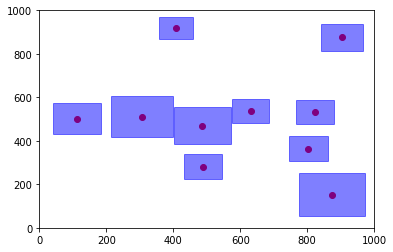

In [8]:
# TEST 产生所有聚类中心及半径
TEST_r = np.array([])
TEST_miu = np.array([])
for i in range(c):
    while 1:
        TEST_r_new , TEST_miu_new = ClusterPlacement(r_k = TEST_r, miu_k = TEST_miu)
        if TEST_r_new != -1:
            break
    TEST_r = np.append(TEST_r , TEST_r_new)
    TEST_miu = np.append(TEST_miu , TEST_miu_new)
    TEST_miu = TEST_miu.reshape(int(len(TEST_miu)/d),d)

# 画图
fig=plt.figure()
ax = fig.add_subplot(111, aspect='auto')
plt.scatter([i[0] for i in TEST_miu],[i[1] for i in TEST_miu],c='r')
plt.axis([0,m,0,m])
for i in range(c):
    ax.add_patch(mpatches.Rectangle(TEST_miu[i]-TEST_r[i], TEST_r[i]*2,TEST_r[i]*2, color = 'b', alpha=0.5))    

## step 2 撒点
n Number  
miu_j Center  
r_j Shape  
Xj   
shape = [-1,0,1,2] # Irregular, Circle, Square, Ellipse, Rectangle,  

### generate_point

In [9]:
def generate_point(r_i,miu_i):
    return ( 2*np.random.random(d) -1 )* r_i + miu_i 

In [10]:
# TEST
generate_point(*ClusterPlacement(np.array([]),np.array([])))

array([621.59625915, 629.04761952])

### sprinkle_point

In [11]:
def sprinkle_point(p, eps, min_pts): # sprinkle surrounding the point p
    # reverse DB-SCAN
    points = np.array([])
    for i in range(min_pts):
        # NOT SURE: "around" here means "within the bounding box". 
        points = np.append(points,generate_point(miu_i=p,r_i=eps)) # note that np.array + array means matrix plus
    return points.reshape(min_pts,2)

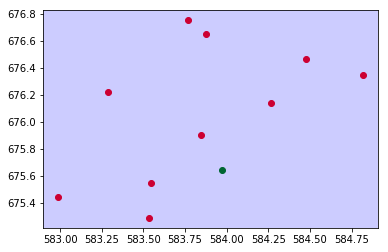

In [12]:
# TEST 在一个点周围撒随机点
TEST_one_r,TEST_one_point = ClusterPlacement(np.array([]),np.array([]))
TEST_sprinlke_point = sprinkle_point(p=TEST_one_point, eps=0.02*TEST_one_r, min_pts=10)

# 画图
fig=plt.figure()
ax = fig.add_subplot(111, aspect='auto')
plt.scatter(*TEST_one_point,c='g')
plt.scatter([i[0] for i in TEST_sprinlke_point],[i[1] for i in TEST_sprinlke_point],c='r')
ax.add_patch(mpatches.Rectangle(TEST_one_point-TEST_one_r, TEST_one_r*2,TEST_one_r*2, color = 'b', alpha=0.2))


### get_a_point

In [13]:
def get_a_point( eps,p, eps_):
    # randomly generate a point with distance of q_, where eps < q_ < eps + eps_ 
    while True:
        p_ = generate_point(miu_i=p, r_i=eps+eps_)
        if np.linalg.norm(p_-p,2) > eps and np.linalg.norm(p_-p,2) < eps+eps_ :
            break
    return p_

In [14]:
# TEST
get_a_point(*ClusterPlacement(np.array([]),np.array([])), eps_=0.002)

array([739.78524296, 264.14062228])

### is_within_cluster_area

In [15]:
def is_within_cluster_area(shape, point, miu_i, r_i, rad_i):
    if shape == 0: # Rectangle. Rad_i = half length in every demension 
        return (abs(point - miu_i)/rad_i < 1 ).all() 
    if shape == 1: # Ellipse. Rad_i = half length in every demension
        return sum((point-miu_i)**2/rad_i)<1

### ClusterPointsGeneration

In [16]:
def ClusterPointsGeneration(n_j, r_j, miu_j, shape, rad_i, alpha): # generate n_j points surrounding the cluster center miu_j
    points=np.array([])
    if shape == -1 : #irregular
        eps=0.02*r_j
        eps_=0.05*r_j
        # initial point p
        # p = generate_point(r_i=r_j, miu_i=miu_j )
        p = miu_j # 直接用聚类中心做初始点可以更集中一些？
        min_pts = int(alpha * n_j)
        points = sprinkle_point(p=p, eps=eps, min_pts=min_pts)
        # iteration p_
        debuggerCounter=0
        while len(points) < n_j:
            p_ = get_a_point(p=p,eps=eps,eps_=eps_)
            points = np.vstack([points, sprinkle_point(p=p_, eps=eps_, min_pts=min_pts)])
            p=p_
            eps = eps_ #NOT SURE
    else:
        while len(points) < n_j:
            p = generate_point(r_i=r_j, miu_i=miu_j )
            if is_within_cluster_area(shape=shape, point=p, miu_i=miu_j, r_i=r_j, rad_i=rad_i):
                if len(points)==0:
                    points = p
                else:
                    points = np.vstack([p,points])
    return points

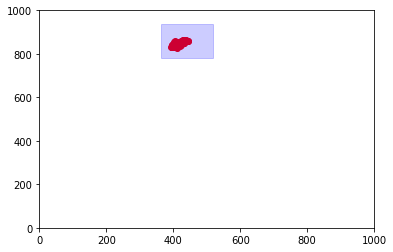

In [17]:
# TEST 为一个聚类撒点
TEST_cluster_r,TEST_cluster_center = ClusterPlacement(np.array([]),np.array([]))
points = ClusterPointsGeneration(
    n_j=100, 
    r_j=TEST_cluster_r, miu_j=TEST_cluster_center,
    shape=-1,
    rad_i=[150,260],
    alpha=0.03
)

# 画图
fig=plt.figure()
ax = fig.add_subplot(111, aspect='auto')
plt.axis([0,m,0,m])
plt.scatter(*TEST_cluster_center,c='g')
plt.scatter([i[0] for i in points],[i[1] for i in points],c='r')
ax.add_patch(mpatches.Rectangle(TEST_cluster_center - TEST_cluster_r, TEST_cluster_r*2,TEST_cluster_r*2, color = 'b', alpha=0.2))


## step 3
不在任何一个聚类内

给定：
yita ，噪点比  
n 总数  
(miu_k, f_k) miu_k - 聚类中心。f_k 包括半径r_k, shape_k, rad_ik, eps_k 
m 范围  


In [18]:
def make_a_noise_point(miu_k, r_k, shape_k, radi_k, eps_k, m):
    num = len(miu_k)
    point = np.random.random(d) * m # make a random point 
    if [ point - miu_k[i] > r_k[i] for i in range(n)].all(): # 不在任何一个矩形半径内
        return point
    else: # in bound but out of cluster
        for i in range(num): 
            if is_within_cluster_area(shape=shape_k[num] , miu_i=miu_k[num] , point=point , r_i=r_k[num],rad_i=radi_k[num]):
                return make_a_noise_point(miu_k, r_k, shape_k, radi_k, eps_k, m) # 新的
        return point

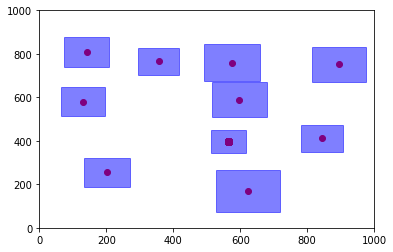

In [19]:
# TEST 产生一个不在任意聚类内的噪点
    # 产生所有的聚类，以及其属性，包括shape rad eps
TEST_r = np.array([])
TEST_miu = np.array([])
TEST_shape = np.array([])
TEST_rad = np.array([])
TEST_eps = np.array([])
for i in range(c):
    while 1:
        TEST_r_new , TEST_miu_new = ClusterPlacement(r_k = TEST_r, miu_k = TEST_miu)
        if TEST_r_new != -1:
            break
    TEST_r = np.append(TEST_r , TEST_r_new)
    TEST_miu = np.append(TEST_miu , TEST_miu_new)
    TEST_miu = TEST_miu.reshape(int(len(TEST_miu)/d),d)
    TEST_shape = np.append(TEST_shape, np.random.randint(-1,2))
    if len(TEST_rad)==1:
        TEST_rad = np.random.random(d) * TEST_r_new
    else: TEST_rad = np.append(TEST_rad, np.random.random(d) * TEST_r_new)
    TEST_eps = 0.01 * TEST_r_new
    # 为其中一个聚类产撒点
TEST_clusterpoints = ClusterPointsGeneration(
    n_j=100, 
    r_j=TEST_r[0], miu_j=TEST_miu[0],
    shape=TEST_shape[0],
    rad_i=TEST_rad[0],
    alpha=0.03
)

    # 加噪点——不在任何一个聚类内
    #############CHECKPOINTHERE####################
    # noisepoint = make_a_noise_point(miu_k=TEST_miu, r_k=TEST_r, eps_k=, m=m, radi_k=)

# 画图
fig=plt.figure()
ax = fig.add_subplot(111, aspect='auto')
plt.axis([0,m,0,m])

plt.scatter([i[0] for i in TEST_miu],[i[1] for i in TEST_miu],c='r')
plt.scatter([i[0] for i in TEST_clusterpoints],[i[1] for i in TEST_clusterpoints],c='r')
for i in range(c):
    ax.add_patch(mpatches.Rectangle(TEST_miu[i]-TEST_r[i], TEST_r[i]*2,TEST_r[i]*2, color = 'b', alpha=0.5))    


In [ ]:
def NoisePointsGeneration(yita, n, miu_k, r_k, shape_k, radi_k, eps_k, m):
    noise_points = np.array([])
    while len(noise_points)< n*yita:
        point = np.random.random(d) * m # make a random point 
        if [ point - miu_k[i] > r_k[i] for i in range(n)].all(): # out of every bounding
            if len(points)==0:
                noise_points = point 
            else:
                noise_points = np.vstack([point,noise_points])
        else: # in bound but out of cluster
            [is_within_cluster_area(shape=shape[i],miu_i=miu_k[i],point=point,r_i=r_k[i],) for i in range(n)].all()
    return noise_points

## 总
并把参数全部写一遍

In [ ]:
n = 1000 # total number
d = 2 # dimension
m = 1000 # max value in each dimension
c = 10 # cluster number 
yita = 0.05 # noise-points/cluster-points

epsilon = 1
r_min = 100
r_max = 500

In [ ]:
# step1
r = np.array([])
miu = np.array([])

for i in range(c):
    while 1:
        r_new,miu_new = ClusterPlacement(r_k = r, miu_k = miu)
        if r_new != -1:
            break
    r = np.append(r , r_new)
    miu = np.append(miu , miu_new)
    miu = miu.reshape(int(len(miu)/d),d)

(r,miu)

In [ ]:
# step2
n_j=n/c # equally divided
rad = np.array([ np.random.random(d)*r[i] for i in range(c)])
alpha = np.array([0.03 for i in range(n)])
shape = np.array([1 for i in range(n)])
points = ClusterPointsGeneration(n_j=n_j, r_j=r[0], miu_j=miu[0], shape=1,rad_i=rad[0], alpha=0.03)

In [ ]:
for i in range(1,c):
    points = np.vstack([
        points , ClusterPointsGeneration(n_j=n_j, r_j=r[i], miu_j=miu[i], shape=shape[i],rad_i=rad[i], alpha=0.03)
   ])

In [ ]:
points

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter([i[0] for i in points],[i[1] for i in points],s=1)
for i in miu:
    plt.scatter(i[0],i[1],c='r')
